In [1]:
using Lux, ADTypes, LuxCUDA, Optimisers, Printf, Random, Statistics, Zygote, LaTeXStrings, Plots

In [2]:
x = reshape(Float32.(collect(range(0, 2π, length=50))), 1,50) 
y = reshape(Float32.(sin.(x)), 1, 50)
plot(x[1, :], y[1, :], legend=false, xlabel=L"x", ylabel=L"y", tick_direction=:out)
scatter!(x[1, :], y[1, :], markersize=3)
model = Chain(Dense(1 => 10, atan),Dense(10 => 10, atan), Dense(10 => 1))
const loss_function = MSELoss()
const dev_cpu = cpu_device()
const dev_gpu = gpu_device()
rng = MersenneTwister()
Random.seed!(rng, 1)
ps, st = Lux.setup(rng, model) |> dev_gpu
opt = Adam(0.001f0)
vjp_rule = AutoZygote()
tstate = Training.TrainState(model, ps, st, opt)


TrainState
    model: Chain{@NamedTuple{layer_1::Dense{typeof(atan), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dense{typeof(atan), Int64, Int64, Nothing, Nothing, Static.True}, layer_3::Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static.True}}, Nothing}((layer_1 = Dense(1 => 10, atan), layer_2 = Dense(10 => 10, atan), layer_3 = Dense(10 => 1)), nothing)
    # of parameters: 141
    # of states: 0
    optimizer: Adam(0.001, (0.9, 0.999), 1.0e-8)
    step: 0

In [3]:
function main(tstate::Training.TrainState, vjp, data, epochs)
    data = data .|> gpu_device()
    for epoch in 1:epochs
        _, loss, _, tstate = Training.single_train_step!(vjp, loss_function, data, tstate)
        if epoch % 50 == 1 || epoch == epochs
            @printf "Epoch: %3d \t Loss: %.5g\n" epoch loss
        end
    end
    return tstate
end

tstate = main(tstate, vjp_rule, (x, y), 5000)

Epoch:   1 	 Loss: 0.4185
Epoch:  51 	 Loss: 0.20777
Epoch: 101 	 Loss: 0.13706
Epoch: 151 	 Loss: 0.10689
Epoch: 201 	 Loss: 0.09229
Epoch: 251 	 Loss: 0.086256
Epoch: 301 	 Loss: 0.083606
Epoch: 351 	 Loss: 0.081927
Epoch: 401 	 Loss: 0.080481
Epoch: 451 	 Loss: 0.079087
Epoch: 501 	 Loss: 0.077715
Epoch: 551 	 Loss: 0.076367
Epoch: 601 	 Loss: 0.075049
Epoch: 651 	 Loss: 0.073762
Epoch: 701 	 Loss: 0.072507
Epoch: 751 	 Loss: 0.071275
Epoch: 801 	 Loss: 0.070046
Epoch: 851 	 Loss: 0.068773
Epoch: 901 	 Loss: 0.067338
Epoch: 951 	 Loss: 0.065519
Epoch: 1001 	 Loss: 0.063281
Epoch: 1051 	 Loss: 0.060505
Epoch: 1101 	 Loss: 0.056834
Epoch: 1151 	 Loss: 0.052234
Epoch: 1201 	 Loss: 0.046892
Epoch: 1251 	 Loss: 0.040845
Epoch: 1301 	 Loss: 0.034316
Epoch: 1351 	 Loss: 0.02771
Epoch: 1401 	 Loss: 0.021472
Epoch: 1451 	 Loss: 0.016005
Epoch: 1501 	 Loss: 0.011541
Epoch: 1551 	 Loss: 0.0081151
Epoch: 1601 	 Loss: 0.0056357
Epoch: 1651 	 Loss: 0.0039404
Epoch: 1701 	 Loss: 0.0028096
Epoch: 1

TrainState
    model: Chain{@NamedTuple{layer_1::Dense{typeof(atan), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dense{typeof(atan), Int64, Int64, Nothing, Nothing, Static.True}, layer_3::Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static.True}}, Nothing}((layer_1 = Dense(1 => 10, atan), layer_2 = Dense(10 => 10, atan), layer_3 = Dense(10 => 1)), nothing)
    # of parameters: 141
    # of states: 0
    optimizer: Adam(0.001, (0.9, 0.999), 1.0e-8)
    step: 5000

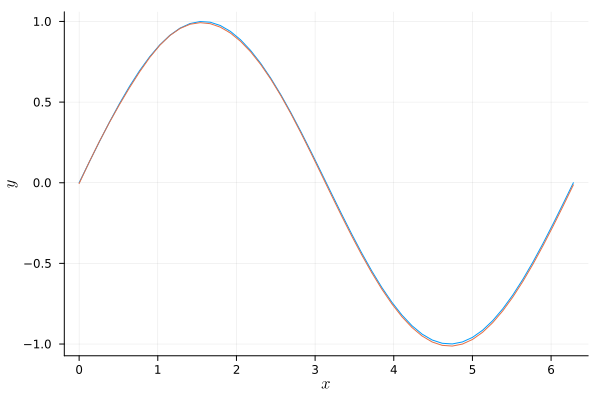

In [72]:
y_pred = dev_cpu(Lux.apply(tstate.model, dev_gpu(x), tstate.parameters, tstate.states)[1])
plot(x[1, :], y[1, :], legend=false, xlabel=L"x", ylabel=L"y", tick_direction=:out)
plot!(x[1, :], y_pred[1, :], legend=false, tick_direction=:out)